In [ ]:
!pip install -q -U datasets einops transformers autoawq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:0

In [ ]:
from typing import Tuple, Any, List, Dict
import math
import os
import copy

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from fastprogress import progress_bar as pb
import datasets
from datasets import load_dataset
import transformers
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, CLIPTextModel, CLIPVisionModel
# from sentence_transformers import SentenceTransformer
import einops
from PIL import Image

import warnings
warnings.simplefilter('ignore')

os.environ['TOKENIZERS_PARALLELISM'] = 'false'

## Configs

In [ ]:
IMAGE_SIZE = (224, 224)
N_PATCHES_PER_IMAGE = 50#(IMAGE_SIZE[0] // vision_encoder.config.patch_size) * (IMAGE_SIZE[1] // vision_encoder.config.patch_size)
# N_COMPRESSED_PATCHES_PER_IMAGE = 10
N_COMPRESSED_PATCHES_PER_IMAGE = 50

IMAGE_TOKEN = '<|imagetoken|>'
# CLS_TOKEN = '<|cls|>'

TEXT_PADDING_MAX_LENGTH = 150 + N_COMPRESSED_PATCHES_PER_IMAGE

N_EPOCHS = 40
TRAIN_BATCH_SIZE = TEST_BATCH_SIZE = 64#32#16#8#32
LR = 5e-5
WEIGHT_DECAY = 1e-2
USE_AMP = False
AMP_DTYPE = torch.bfloat16

dtype = torch.float32#torch.bfloat16
llm_dtype = torch.bfloat16

TRAIN_VISION_ENCODER = True

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load LLM Model and Tokenizer

In [ ]:
if device == 'cuda':
    tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct-AWQ")
    llm_model = AutoModel.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct-AWQ", torch_dtype=llm_dtype).to(device).eval()
else:
    tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct")
    llm_model = AutoModel.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", torch_dtype=llm_dtype).to(device).eval()

You have loaded an AWQ model on CPU and have a CUDA device available, make sure to set your model on a GPU device in order to run your model.
We suggest you to set `torch_dtype=torch.float16` for better efficiency with AWQ.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [ ]:
_ = llm_model.requires_grad_(False)

In [ ]:
tokenizer.add_tokens([IMAGE_TOKEN], special_tokens=True)

1

In [ ]:
IMAGE_TOKEN_ID = tokenizer.convert_tokens_to_ids(IMAGE_TOKEN)

## Load Vision Encoder Model

In [ ]:
vision_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32", torch_dtype=dtype, attn_implementation="sdpa").to(device).eval()

In [ ]:
_ = vision_encoder.requires_grad_(False)

## Prepare Dataset

In [ ]:
data_part_no_list = [0]
hf_dataset = load_dataset('jackyhate/text-to-image-2M', trust_remote_code=True, data_files=[f"data_512_2M/data_00000{no}.tar" for no in data_part_no_list], cache_dir='./cache_data')['train']

In [ ]:
# hf_dataset_posi = hf_dataset
hf_dataset_posi = hf_dataset.select(range(10000))
hf_dataset_nega = copy.deepcopy(hf_dataset_posi)

# negative samplig by shuffling text column randomly
hf_dataset_nega = hf_dataset_nega.shuffle()
hf_dataset_nega = hf_dataset_nega.remove_columns(['json']).add_column("json", hf_dataset_posi['json'])

hf_dataset_posi = hf_dataset_posi.add_column("label", len(hf_dataset_posi) * [1])
hf_dataset_nega = hf_dataset_nega.add_column("label", len(hf_dataset_nega) * [0])

Flattening the indices:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
hf_dataset_sampled = datasets.concatenate_datasets([hf_dataset_posi, hf_dataset_nega])

In [ ]:
hf_dataset_sampled

Dataset({
    features: ['__key__', '__url__', 'jpg', 'json', 'label'],
    num_rows: 20000
})

In [ ]:
image_transforms = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(IMAGE_SIZE, interpolation=torchvision.transforms.InterpolationMode.BILINEAR),
        torchvision.transforms.CenterCrop(IMAGE_SIZE),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.5], [0.5]),
    ]
)

In [ ]:
@torch.inference_mode()
def tokenize_text(texts, tokenizer=tokenizer):
    texts = [f'<|im_start|>{N_COMPRESSED_PATCHES_PER_IMAGE * IMAGE_TOKEN}<|im_end|> {text}' for text in texts]
    # texts = [f'<|im_start|>{IMAGE_TOKEN}<|im_end|> {text}' for text in texts]
    inputs = tokenizer(texts, padding='max_length', max_length=TEXT_PADDING_MAX_LENGTH, truncation=True, return_tensors='pt')
    inputs = {k: v.to(device) for k, v in inputs.items()}
    # text_encoder_output = text_encoder(**inputs)
    # text_emb = text_encoder_output['last_hidden_state']
    return inputs

def preprocess_data(examples, vision_encoder=vision_encoder):
    # print('preprocess_data')
    images = [image.convert("RGB") for image in examples['jpg']]
    images = [image_transforms(image) for image in images]
    image_embs = vision_encoder(torch.stack(images).to(device)).last_hidden_state

    examples["pixel_values"] = images
    examples["image_embs"] = image_embs
    tokenized_inputs = tokenize_text([d['prompt'] for d in examples['json']])
    examples["input_ids"] = tokenized_inputs['input_ids']
    examples["attention_mask"] = tokenized_inputs['attention_mask']
    examples["label"] = torch.tensor(examples['label'], dtype=torch.long).to(device)

    return examples

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format)
    image_embs = torch.stack([example["image_embs"] for example in examples])
    input_ids = torch.stack([example["input_ids"] for example in examples])
    attention_mask = torch.stack([example["attention_mask"] for example in examples])
    label = torch.stack([example["label"] for example in examples])

    return {
        "pixel_values": pixel_values,
        'image_embs': image_embs,
        "input_ids": input_ids,
        'attention_mask': attention_mask,
        "label": label,
    }

In [ ]:
%%time
hf_dataset_sampled = hf_dataset_sampled.with_transform(preprocess_data)

CPU times: user 2.8 s, sys: 860 ms, total: 3.66 s
Wall time: 4.09 s


In [ ]:
_d = hf_dataset_sampled[0]

In [ ]:
_d.keys()

dict_keys(['__key__', '__url__', 'jpg', 'json', 'label', 'pixel_values', 'image_embs', 'input_ids', 'attention_mask'])

In [ ]:
hf_dataset_sampled = hf_dataset_sampled.train_test_split(test_size=0.1, shuffle=True)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    hf_dataset_sampled['train'],
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=TRAIN_BATCH_SIZE,
)
test_dataloader = torch.utils.data.DataLoader(
    hf_dataset_sampled['test'],
    shuffle=False,
    collate_fn=collate_fn,
    batch_size=TEST_BATCH_SIZE,
)

## Image Text Interleaved Embedding Utils

In [ ]:
def convert_to_text_vision_interleaved_emb(
    input_ids: torch.LongTensor,
    attention_mask: torch.LongTensor,
    llm_model: torch.nn.Module,
    vision_encoder: torch.nn.Module,
    pre_calc_image_emb: torch.FloatTensor = None,
    vision_emb_compresser: torch.nn.Module = None,
    text_emb_projector: torch.nn.Module = None,
    images: torch.FloatTensor = [],
    image_token_id: int = IMAGE_TOKEN_ID,
    debug: bool = False,
    validate_image_emb: bool = True,
):
    """
    input_ids: (bs, max_seq_len)
    attention_mask: (bs, max_seq_len)
    pre_calc_image_emb: (n_images, n_image_tokens_per_image, image_emb_dim)
    """
    if validate_image_emb:
        _image_emb = llm_model.embed_tokens(torch.tensor([IMAGE_TOKEN_ID]).long().to(input_ids.device))   # (1, text_emb_dim)
        # _image_emb = llm_model.embed_tokens(torch.tensor([151644]).long())   # (1, text_emb_dim)
    text_embed = llm_model.embed_tokens(input_ids)  # (bs, max_seq_len) => (bs, max_seq_len, text_emb_dim)
    if text_emb_projector is not None:
        text_embed = text_emb_projector(text_embed)  # (bs, max_seq_len, text_emb_dim) => (bs, max_seq_len, text_emb_dim)
    if pre_calc_image_emb is not None:
        vision_embed = pre_calc_image_emb  # (n_images, n_image_token, image_emb_dim)
    else:
        vision_embed = vision_encoder(images).last_hidden_state  # (n_images, ch, h, w) => (n_images, n_image_token, image_emb_dim)
    if vision_emb_compresser is not None:
        vision_embed = vision_emb_compresser(vision_embed)  # (n_images, n_image_token, image_emb_dim) => (n_images, n_image_token_compressed, image_emb_dim)
    n_images, n_image_token_compressed_per_image, emb_dim = vision_embed.shape
    assert (input_ids == image_token_id).sum() == (n_images * n_image_token_compressed_per_image)
    assert text_embed.shape[-1] == vision_embed.shape[-1]  # text_emb_dim == image_emb_dim
    bs = input_ids.shape[0]

    vision_embed = einops.rearrange(vision_embed, 'ni nt d -> (ni nt) d')  # -> (n_images x n_image_token_compressed_per_image, emb_dim)
    text_embed = einops.rearrange(text_embed, 'bs sl d -> (bs sl) d')  # -> (bs x max_seq_len, emb_dim)
    image_token_pos_mask = input_ids == image_token_id  # (bs, max_seq_len)
    image_token_pos_mask = einops.rearrange(image_token_pos_mask, 'bs sl -> (bs sl)')  # -> (bs x max_seq_len,)
    assert vision_embed.shape[0] == image_token_pos_mask.sum()
    # print(text_embed.requires_grad, vision_embed.requires_grad)
    text_embed[image_token_pos_mask] = vision_embed.to(text_embed.dtype)   # (bs x max_seq_len, emb_dim)
    text_vision_emb = einops.rearrange(text_embed, '(bs sl) d -> bs sl d', bs=bs)  # -> (bs, max_seq_len, emb_dim)
    image_token_pos_mask = einops.rearrange(image_token_pos_mask, '(bs sl) -> bs sl', bs=bs)  # -> (bs, max_seq_len)
    # print(text_vision_emb.requires_grad)

    text_vision_mask = attention_mask

    if validate_image_emb:
        # ensure placeholder image token emb is replaced by actual image emb of vision encoder output
        assert not (text_vision_emb == _image_emb.repeat(text_vision_emb.shape[0], text_vision_emb.shape[1], 1)).all(dim=-1).any()
    return text_vision_emb, text_vision_mask, image_token_pos_mask

# def convert_to_text_vision_interleaved_emb(
#     input_ids: torch.LongTensor,
#     attention_mask: torch.LongTensor,
#     llm_model: torch.nn.Module,
#     vision_encoder: torch.nn.Module,
#     pre_calc_image_emb: torch.FloatTensor = None,
#     vision_emb_compresser: torch.nn.Module = None,
#     text_emb_projector: torch.nn.Module = None,
#     images: torch.FloatTensor = [],
#     image_token_id: int = IMAGE_TOKEN_ID,
#     debug: bool = False,
# ):
#     text_embed = llm_model.embed_tokens(input_ids)  # (bs, max_seq_len) => (bs, max_seq_len, text_emb_dim)
#     if text_emb_projector is not None:
#         text_embed = text_emb_projector(text_embed)  # (bs, max_seq_len, text_emb_dim) => (bs, max_seq_len, text_emb_dim)
#     if pre_calc_image_emb is not None:
#         assert (input_ids == image_token_id).sum() == pre_calc_image_emb.shape[0]
#         vision_embed = pre_calc_image_emb  # (n_images, n_image_token, image_emb_dim)
#     else:
#         assert (input_ids == image_token_id).sum() == len(images)
#         vision_embed = vision_encoder(images).last_hidden_state  # (n_images, ch, h, w) => (n_images, n_image_token, image_emb_dim)
#     if vision_emb_compresser is not None:
#         vision_embed = vision_emb_compresser(vision_embed)  # (n_images, n_image_token, image_emb_dim) => (n_images, n_image_token_compressed, image_emb_dim)
#     assert text_embed.shape[-1] == vision_embed.shape[-1]  # text_emb_dim == image_emb_dim
#     bs = input_ids.shape[0]
#     text_vison_emb_list = []
#     text_vison_mask_list = []
#     vision_pos_mask_list = []
#     image_idx = 0
#     for batch_idx in range(bs):
#         # 1. count the number of image token in this single text
#         image_token_pos_list = torch.where(input_ids[batch_idx] == IMAGE_TOKEN_ID)[0].tolist()
#         if len(image_token_pos_list) == 0:
#             text_vison_emb_list.append(text_embed[batch_idx])
#             text_vison_mask_list.append(attention_mask[batch_idx])
#             continue
#         # 2. calculate text chunk start/end pos index list with image position IMAGE_PLACEHOLDER : [(text_start_pos1, text_end_pos1), 'IMAGE_PLACEHOLDER', (text_start_pos2, text_end_pos2), ...]
#         text_only_pos_start_end_list = [['IMAGE_PLACEHOLDER', (image_token_pos_list[j] + 1, image_token_pos_list[j+1] - 1)] for j in range(len(image_token_pos_list) - 1)]  # for the case where there are multiple images for this text
#         text_only_pos_start_end_list = sum(text_only_pos_start_end_list, [])[1:]  # [(text_start_pos1, text_end_pos1), 'IMAGE_PLACEHOLDER', (text_start_pos2, text_end_pos2), ...]
#         first_image_token_pos = image_token_pos_list[0]
#         last_image_token_pos = image_token_pos_list[-1]
#         if first_image_token_pos != 0:
#             # if text does not starts with image token, insert text begin -> first image token pos -1
#             text_only_pos_start_end_list = [(0, first_image_token_pos - 1 if first_image_token_pos > 1 else 1), 'IMAGE_PLACEHOLDER'] + text_only_pos_start_end_list
#         if last_image_token_pos != input_ids.shape[1] - 1:
#             # if text does not ends with image token, insert last image token pos + 1 -> text end
#             if len(text_only_pos_start_end_list) > 0 and text_only_pos_start_end_list[-1] == 'IMAGE_PLACEHOLDER':
#                 text_only_pos_start_end_list += [(last_image_token_pos + 1, input_ids.shape[1])]
#             else:
#                 text_only_pos_start_end_list += ['IMAGE_PLACEHOLDER', (last_image_token_pos + 1, input_ids.shape[1])]
#         if debug:
#             print(text_only_pos_start_end_list)
#         assert sum([p == 'IMAGE_PLACEHOLDER' for p in text_only_pos_start_end_list]) == len(image_token_pos_list)
#         text_vision_emb_chunk_list = []
#         text_vison_mask_chunk_list = []
#         vision_pos_mask_chunk_list = []
#         for text_start_end_pos in text_only_pos_start_end_list:
#             if text_start_end_pos == 'IMAGE_PLACEHOLDER':
#                 emb = single_image_emb = vision_embed[image_idx]  # (n_image_token, image_emb_dim)
#                 image_idx += 1
#                 mask = torch.ones(single_image_emb.shape[0]).to(single_image_emb.device)  # (n_image_token,)
#                 vision_pos_mask = torch.ones(single_image_emb.shape[0]).to(single_image_emb.device)  # (n_image_token,)
#                 if debug:
#                     print('IMAGE_PLACEHOLDER')
#             else:
#                 start_pos, end_pos = text_start_end_pos
#                 emb = text_chunk_emb = text_embed[batch_idx][text_start_end_pos[0]:text_start_end_pos[1]]  # (seq_len_chunk, text_emb_dim)
#                 mask = attention_mask[batch_idx][text_start_end_pos[0]:text_start_end_pos[1]]  # (seq_len_chunk,)
#                 vision_pos_mask = torch.zeros(emb.shape[0]).to(emb.device)  # (seq_len_chunk,)
#                 if debug:
#                     print(tokenizer.decode(input_ids[batch_idx][text_start_end_pos[0]:text_start_end_pos[1]]))
#             text_vision_emb_chunk_list.append(emb)
#             text_vison_mask_chunk_list.append(mask)
#             vision_pos_mask_chunk_list.append(vision_pos_mask)
#         text_vison_emb_list.append(
#             torch.cat(text_vision_emb_chunk_list, dim=0)  # (n_images_for_this_text x n_image_token + (max_seq_len - n_images_for_this_text), emb_dim)
#         )
#         text_vison_mask_list.append(
#             torch.cat(text_vison_mask_chunk_list, dim=0)  # (n_images_for_this_text x n_image_token + (max_seq_len - n_images_for_this_text),)
#         )
#         vision_pos_mask_list.append(
#             torch.cat(vision_pos_mask_chunk_list, dim=0)  # (n_images_for_this_text x n_image_token + (max_seq_len - n_images_for_this_text),)
#         )
#     max_vison_text_seq_len = max([emb.shape[0] for emb in text_vison_emb_list])
#     # zero pad to max seq len
#     text_vison_emb_list = [
#         torch.cat([emb, torch.zeros(max_vison_text_seq_len - emb.shape[0], emb.shape[1], dtype=emb.dtype).to(emb.device)], dim=0) for emb in text_vison_emb_list
#     ]
#     text_vison_mask_list = [
#         torch.cat([mask, torch.zeros(max_vison_text_seq_len - mask.shape[0], dtype=mask.dtype).to(mask.device)], dim=0) for mask in text_vison_mask_list
#     ]
#     vision_pos_mask_list = [
#         torch.cat([mask, torch.zeros(max_vison_text_seq_len - mask.shape[0], dtype=mask.dtype).to(mask.device)], dim=0) for mask in vision_pos_mask_list
#     ]
#     text_vison_emb = torch.stack(text_vison_emb_list, dim=0)  # (bs, max_vison_text_seq_len, emb_dim)
#     text_vison_mask = torch.stack(text_vison_mask_list, dim=0)  # (bs, max_vison_text_seq_len)
#     vision_pos_mask = torch.stack(vision_pos_mask_list, dim=0)  # (bs, max_vison_text_seq_len)
#     return text_vison_emb, text_vison_mask, vision_pos_mask

## Model

In [ ]:
def positionalencoding1d(d_model, length, dtype=dtype):
    """
    :param d_model: dimension of the model
    :param length: length of positions
    :return: length*d_model position matrix
    """
    if d_model % 2 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dim (got dim={:d})".format(d_model))
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                         -(math.log(10000.0) / d_model)))
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)

    return pe.to(dtype)

### Projector

In [ ]:
class TextEmbProjectorMLP(nn.Module):

    def __init__(self, in_dim, intermediate_dim=512, out_dim=None, dropout=0.05, bias=True):
        super().__init__()
        if out_dim is None:
            out_dim = in_dim
        self._head = nn.Sequential(
            nn.Linear(in_dim, intermediate_dim, bias=bias),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(intermediate_dim, out_dim, bias=bias),
        )

    def forward(self, x):
        return self._head(x)

### Image Emb Compressor

In [ ]:
class ImageEmbCompressorCrossAttn(nn.Module):
    def __init__(
        self,
        in_dim: int,
        compressed_n_tokens: int,
        hidden_size: int = None,
        out_dim: int = None,
        dropout: float = 0.05,
        num_heads: int = 8,
        n_max_tokens: int = N_PATCHES_PER_IMAGE,
    ):
        super().__init__()
        if hidden_size is None:
            hidden_size = in_dim
        self.query_compressed_tokens = nn.Parameter(torch.rand(1, compressed_n_tokens, hidden_size))  # lernable query for compressed tokens
        self.x_proj = nn.Linear(in_dim, hidden_size)
        self.out_proj = nn.Linear(hidden_size, out_dim) if out_dim is not None and out_dim != hidden_size else nn.Identity
        self.act = nn.GELU()
        self.dropout = dropout
        self.norm = nn.LayerNorm(hidden_size)
        self.x_pe = positionalencoding1d(hidden_size, N_PATCHES_PER_IMAGE).unsqueeze(0)
        self.num_heads = num_heads

    def forward(self, x):
        """
        x: (bs, n_patches(n_tokens), patch_emb_dim)
        """
        # 1. input projection
        x_proj = self.act(self.norm(self.x_proj(x)))  # (bs, n_tokens, patch_emb_dim) => (bs, n_tokens, hidden_size)
        if self.x_pe is not None:
            x_proj = x_proj + self.x_pe[:, :x_proj.shape[1], :x_proj.shape[2]].to(x.device).to(x_proj.dtype)

        # 2. compression by cross attention
        hidden_size = x_proj.shape[-1]
        x_proj = einops.rearrange(x_proj, 'b sl (nh d) -> b nh sl d', nh=self.num_heads, d=hidden_size // self.num_heads)  # (bs, num_heads, n_tokens, hidden_size_head)
        query_compressed_tokens = einops.rearrange(self.query_compressed_tokens, 'b sl (nh d) -> b nh sl d', nh=self.num_heads, d=hidden_size // self.num_heads)
        compressed = F.scaled_dot_product_attention(
            query=query_compressed_tokens.to(x_proj.device).to(x_proj.dtype), key=x_proj, value=x_proj,
            dropout_p=self.dropout, is_causal=False
        )  # (bs, num_heads, compressed_n_tokens, hidden_size)
        compressed = einops.rearrange(compressed, 'b nh sl d -> b sl (nh d)', nh=self.num_heads, d=hidden_size // self.num_heads)  # (bs, compressed_n_tokens, hidden_size)

        # 3. output projection
        compressed = self.act(self.norm(compressed))  # (bs, compressed_n_tokens, hidden_size)
        compressed = self.out_proj(compressed)  # (bs, compressed_n_tokens, out_dim)
        return compressed

### Classification Head

In [ ]:
class ClassifierMLP(nn.Module):

    def __init__(self, in_dim, intermediate_dim=512, n_classes=1, dropout=0.05, bias=True):
        super().__init__()
        self._head = nn.Sequential(
            nn.Linear(in_dim, intermediate_dim, bias=bias),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(intermediate_dim, n_classes, bias=bias),
        )

    def forward(self, x):
        """
        x: (bs, seq_len, dim)
        """
        logits = self._head(x)  # (bs, dim) => (bs, n_classes)
        return logits

class ClassifierWithPoolMLP(nn.Module):

    def __init__(self, in_dim, intermediate_dim=512, n_classes=1, dropout=0.05, bias=True):
        super().__init__()
        self._head = nn.Sequential(
            nn.Linear(in_dim, intermediate_dim, bias=bias),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(intermediate_dim, n_classes, bias=bias),
        )

    def forward(self, x, vision_emb_pos = None):
        """
        x: (bs, seq_len, dim)
        """
        if vision_emb_pos is not None:
            x = x * vision_emb_pos.unsqueeze(-1).repeat((1, 1, x.shape[-1])).to(x.dtype)
        x = self._mean_pool(x)  # (bs, seq_len, dim) => (bs, dim)
        logits = self._head(x)  # (bs, dim) => (bs, n_classes)
        return logits

    def _mean_pool(self, x):
        return x.mean(dim=1)  # (bs, seq_len, dim) => (bs, dim)

class ClassifierWithAttn(nn.Module):

    def __init__(self, in_dim, intermediate_dim=512, n_classes=1, dropout=0.05, bias=True):
        super().__init__()
        self.dropout = dropout
        self._in_proj = nn.Sequential(
            nn.Linear(in_dim, intermediate_dim, bias=bias),
            nn.Dropout(dropout),
            nn.GELU(),
        )
        self._cls_emb = nn.Parameter(torch.rand(1, 1, intermediate_dim))
        self._act = nn.GELU()
        self._head = nn.Sequential(
            nn.Linear(intermediate_dim, n_classes, bias=bias),
        )

    def forward(self, x):
        """
        x: (bs, seq_len, dim)
        """
        bs, sl, dim = x.shape
        x = self._in_proj(x)  # (bs, seq_len, dim) => (bs, seq_len, intermediate_dim)
        x = x + F.scaled_dot_product_attention(
            query=x, key=x, value=x,
            dropout_p=self.dropout, is_causal=False
        )
        cls_emb = F.scaled_dot_product_attention(
            query=self._cls_emb.repeat((bs, 1, 1)).to(x.dtype), key=x, value=x,
            dropout_p=self.dropout, is_causal=False
        )  # (bs, seq_len, intermediate_dim) => (bs, 1, intermediate_dim)
        cls_emb = self._act(cls_emb)
        logits = self._head(cls_emb)  # (bs, dim) => (bs, n_classes)
        return logits


In [ ]:
# text_emb_projector = TextEmbProjectorMLP(
#     in_dim=llm_model.config.hidden_size,
#     intermediate_dim=1024,
#     out_dim=llm_model.config.hidden_size,
# ).to(dtype).to(device)
text_emb_projector = None

image_emb_compressor = ImageEmbCompressorCrossAttn(
    in_dim=vision_encoder.config.hidden_size,
    compressed_n_tokens=N_COMPRESSED_PATCHES_PER_IMAGE,
    hidden_size=1024,
    out_dim=llm_model.config.hidden_size,
    dropout=0.0,
    num_heads=8,
).to(dtype).to(device)
# image_emb_compressor = nn.Sequential(
#     nn.Linear(vision_encoder.config.hidden_size, llm_model.config.hidden_size),
#     nn.GELU(),
# ).to(dtype).to(device)

classifier = ClassifierWithAttn(
# classifier = ClassifierWithPoolMLP(
# classifier = ClassifierMLP(
    in_dim=llm_model.config.hidden_size,
    intermediate_dim=1024,
    n_classes=1,
    dropout=0.0,
    bias=False,
).to(dtype).to(device)

vision_encoder = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch32", torch_dtype=dtype, attn_implementation="sdpa").to(device)
llm_model = AutoModel.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct-AWQ", torch_dtype=llm_dtype).to(device)

We suggest you to set `torch_dtype=torch.float16` for better efficiency with AWQ.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [ ]:
llm_model = llm_model.eval().requires_grad_(False)

In [ ]:
torch.save(vision_encoder.state_dict(), 'init_vision_encoder.pt')
torch.save(classifier.state_dict(), 'init_classifier.pt')
torch.save(image_emb_compressor.state_dict(), 'init_image_emb_compressor.pt')
torch.save(llm_model.state_dict(), 'init_llm_model.pt')

In [ ]:
# train_models = [text_emb_projector, image_emb_compressor, classifier]
train_models = [image_emb_compressor, classifier, vision_encoder]
# train_models = [image_emb_compressor, classifier, vision_encoder, llm_model]

In [ ]:
# _text_vison_emb, _text_vison_mask, _vision_pos_mask = convert_to_text_vision_interleaved_emb(
#     input_ids=_batch['input_ids'],
#     attention_mask=_batch['attention_mask'],
#     llm_model=llm_model,
#     vision_encoder=vision_encoder,
#     pre_calc_image_emb=_batch['image_embs'].to(dtype),
#     vision_emb_compresser=image_emb_compressor,
#     text_emb_projector=text_emb_projector,
#     images=[],
#     image_token_id=IMAGE_TOKEN_ID,
#     debug=False,
# )
# print(_text_vison_emb.shape, _text_vison_mask.shape, _vision_pos_mask.shape)

# _llm_out = llm_model(
#     attention_mask=_text_vison_mask,
#     inputs_embeds=_text_vison_emb,
# )
# print(_llm_out.last_hidden_state.shape)

# pred_logits = classifier(_llm_out.last_hidden_state)
# print(pred_logits.shape)

In [ ]:
def batch_to_device(batch: Dict[str, torch.Tensor], device: torch.device) -> Dict[str, torch.Tensor]:
    return {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}

In [ ]:
def get_trainable_params(models):
    params = []
    for model in models:
        params += [p for p in model.parameters() if p.requires_grad]
    return params

In [ ]:
optimizer = torch.optim.AdamW(
    # nn.ModuleList(train_models).parameters(),
    get_trainable_params(train_models),
    lr=LR, weight_decay=WEIGHT_DECAY
)

scheduler = transformers.get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=1*len(train_dataloader),
    num_training_steps=N_EPOCHS*len(train_dataloader),
)

scaler = torch.amp.GradScaler(device='cuda', enabled=USE_AMP)

In [ ]:
loss_history = []
train_acc_history = []
test_acc_history = []

for epoch in range(N_EPOCHS):
    # Train phase
    [m.train() for m in train_models]
    epoch_loss = 0.0
    pred_labels = []
    true_labels = []
    for batch in pb(train_dataloader):
        batch = batch_to_device(batch, device)
        optimizer.zero_grad()
        with torch.autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=USE_AMP):
            # 1.
            text_vison_emb, text_vison_mask, vision_pos_mask = convert_to_text_vision_interleaved_emb(
                input_ids=batch['input_ids'],
                attention_mask=batch['attention_mask'],
                llm_model=llm_model,
                vision_encoder=vision_encoder,
                pre_calc_image_emb=None if TRAIN_VISION_ENCODER else batch['image_embs'].to(dtype),
                vision_emb_compresser=image_emb_compressor,
                text_emb_projector=text_emb_projector,
                images=batch['pixel_values'] if TRAIN_VISION_ENCODER else [],
                image_token_id=IMAGE_TOKEN_ID,
                debug=False,
            )
            # 2.
            llm_out = llm_model(
                attention_mask=text_vison_mask,
                inputs_embeds=text_vison_emb.to(llm_dtype),
            )
            # 3.
            classifier_inputs = llm_out.last_hidden_state.to(dtype)
            # classifier_inputs = (
            #     (text_vison_emb * vision_pos_mask.unsqueeze(-1).repeat((1, 1, text_vison_emb.shape[-1]))).mean(dim=1).to(text_vison_emb.dtype)
            #     -
            #     (text_vison_emb * (1.0 - vision_pos_mask).unsqueeze(-1).repeat((1, 1, text_vison_emb.shape[-1]))).mean(dim=1).to(text_vison_emb.dtype)
            # )
            # classifier_inputs = text_vison_emb.mean(dim=1)
            pred_logits = classifier(classifier_inputs)
            loss = torch.nn.functional.binary_cross_entropy_with_logits(pred_logits.squeeze().float(), batch['label'].float())
            # loss = torch.nn.functional.cross_entropy(pred_logits.squeeze().float(), batch['label'].float())
            if torch.isnan(loss):
                print('loss is nan')
                raise Exception()
            pred_labels.append((torch.nn.functional.sigmoid(pred_logits) > 0.5).long().cpu().detach())
            true_labels.append(batch['label'].cpu().detach())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        # loss.backward()
        # optimizer.step()
        scaler.update()
        scheduler.step()
        epoch_loss += loss.cpu().detach()
    pred_labels = torch.cat(pred_labels, dim=0).squeeze()
    true_labels = torch.cat(true_labels, dim=0).squeeze()
    acc = (pred_labels == true_labels).float().mean()
    train_acc_history.append(acc)
    loss_history.append(epoch_loss / len(train_dataloader))
    print(f'epoch {epoch} : loss {loss_history[-1]} : acc {acc}, {pred_labels.float().mean()}')

    # Ealuluation Phase
    [m.eval() for m in train_models]
    pred_labels = []
    true_labels = []
    with torch.inference_mode():
        for batch in pb(test_dataloader):
            batch = batch_to_device(batch, device)
            with torch.autocast(device_type="cuda", dtype=AMP_DTYPE, enabled=USE_AMP):
                # 1.
                text_vison_emb, text_vison_mask, vision_pos_mask = convert_to_text_vision_interleaved_emb(
                    input_ids=batch['input_ids'],
                    attention_mask=batch['attention_mask'],
                    llm_model=llm_model,
                    vision_encoder=vision_encoder,
                    pre_calc_image_emb=None if TRAIN_VISION_ENCODER else batch['image_embs'].to(dtype),
                    vision_emb_compresser=image_emb_compressor,
                    text_emb_projector=text_emb_projector,
                    images=batch['pixel_values'] if TRAIN_VISION_ENCODER else [],
                    image_token_id=IMAGE_TOKEN_ID,
                    debug=False,
                )
                # 2.
                llm_out = llm_model(
                    attention_mask=text_vison_mask,
                    inputs_embeds=text_vison_emb.to(llm_dtype),
                )
                # 3.
                classifier_inputs = llm_out.last_hidden_state.to(dtype)
                # classifier_inputs = (
                #     (text_vison_emb * vision_pos_mask.unsqueeze(-1).repeat((1, 1, text_vison_emb.shape[-1]))).mean(dim=1).to(text_vison_emb.dtype)
                #     -
                #     (text_vison_emb * (1.0 - vision_pos_mask).unsqueeze(-1).repeat((1, 1, text_vison_emb.shape[-1]))).mean(dim=1).to(text_vison_emb.dtype)
                # )
                # classifier_inputs = text_vison_emb.mean(dim=1)
                pred_logits = classifier(classifier_inputs)
                loss = torch.nn.functional.binary_cross_entropy_with_logits(pred_logits.squeeze().float(), batch['label'].float())
                # loss = torch.nn.functional.cross_entropy(pred_logits.squeeze().float(), batch['label'].float())
                if torch.isnan(loss):
                    print('loss is nan')
                    raise Exception()
                pred_labels.append((torch.nn.functional.sigmoid(pred_logits) > 0.5).long().cpu().detach())
                true_labels.append(batch['label'].cpu().detach())
    pred_labels = torch.cat(pred_labels, dim=0).squeeze()
    true_labels = torch.cat(true_labels, dim=0).squeeze()
    acc = (pred_labels == true_labels).float().mean()
    test_acc_history.append(acc)
    print(f'epoch {epoch} : test acc {test_acc_history[-1]}, {pred_labels.float().mean()}')

    print(scheduler.get_lr())

epoch 0 : loss 0.7563520669937134 : acc 0.5028333067893982, 0.5230000019073486


epoch 0 : test acc 0.5174999833106995, 0.12300000339746475
[5e-05]


epoch 1 : loss 0.7352461218833923 : acc 0.5143333077430725, 0.499833345413208


epoch 1 : test acc 0.5145000219345093, 0.18199999630451202
[4.9918932703355256e-05]


epoch 2 : loss 0.7174243330955505 : acc 0.5261111259460449, 0.5078333616256714


epoch 2 : test acc 0.5270000100135803, 0.1404999941587448
[4.967625656594782e-05]


epoch 3 : loss 0.6994267702102661 : acc 0.5503888726234436, 0.5076666474342346


epoch 3 : test acc 0.5504999756813049, 0.3889999985694885
[4.92735454356513e-05]


epoch 4 : loss 0.6920608878135681 : acc 0.5590000152587891, 0.5111666917800903


epoch 4 : test acc 0.5435000061988831, 0.8259999752044678
[4.8713411048678635e-05]


epoch 5 : loss 0.6880355477333069 : acc 0.5641111135482788, 0.5106111168861389


epoch 5 : test acc 0.49950000643730164, 0.09799999743700027
[4.799948609147061e-05]


epoch 6 : loss 0.7315786480903625 : acc 0.5020555257797241, 0.49933332204818726


epoch 6 : test acc 0.5065000057220459, 0.07999999821186066
[4.713640064133025e-05]


epoch 7 : loss 0.7329808473587036 : acc 0.49905556440353394, 0.5086666941642761


epoch 7 : test acc 0.4984999895095825, 0.9980000257492065
[4.6129752138594874e-05]


epoch 8 : loss 0.7239512205123901 : acc 0.4970555603504181, 0.5065555572509766


epoch 8 : test acc 0.4970000088214874, 0.9915000200271606
[4.498606908508754e-05]


epoch 9 : loss 0.7123839855194092 : acc 0.496444433927536, 0.5048333406448364


epoch 9 : test acc 0.4945000112056732, 0.3779999911785126
[4.371276870427753e-05]


epoch 10 : loss 0.7094340324401855 : acc 0.4993889033794403, 0.496111124753952


epoch 10 : test acc 0.4934999942779541, 0.20800000429153442
[4.231810883773999e-05]


epoch 11 : loss 0.7280502915382385 : acc 0.4992222189903259, 0.4953888952732086


epoch 11 : test acc 0.48399999737739563, 0.5044999718666077
[4.0811134389884433e-05]


epoch 12 : loss 0.7166852951049805 : acc 0.49227777123451233, 0.5012221932411194


epoch 12 : test acc 0.47099998593330383, 0.715499997138977
[3.920161866827889e-05]


epoch 13 : loss 0.719696581363678 : acc 0.4914444386959076, 0.4976111054420471


epoch 13 : test acc 0.4544999897480011, 0.3140000104904175
[3.7500000000000003e-05]


epoch 14 : loss 0.7116528749465942 : acc 0.5014444589614868, 0.500166654586792


epoch 14 : test acc 0.47450000047683716, 0.5009999871253967
[3.5717314035076355e-05]


epoch 15 : loss 0.7147049903869629 : acc 0.5040000081062317, 0.49861112236976624


epoch 15 : test acc 0.492000013589859, 0.11949999630451202
[3.386512217606339e-05]


epoch 16 : loss 0.7148517370223999 : acc 0.4950000047683716, 0.4953888952732086


epoch 16 : test acc 0.48899999260902405, 0.01549999974668026
[3.195543659791132e-05]


epoch 17 : loss 0.7125022411346436 : acc 0.4939444363117218, 0.5105555653572083


epoch 17 : test acc 0.4375, 0.5220000147819519
[3.0000642344401113e-05]


epoch 18 : loss 0.7082412242889404 : acc 0.49666666984558105, 0.4993889033794403


epoch 18 : test acc 0.4555000066757202, 0.7829999923706055
[2.8013417006383076e-05]


epoch 19 : loss 0.7090917825698853 : acc 0.49522221088409424, 0.4929444491863251


epoch 19 : test acc 0.4925000071525574, 0.9800000190734863
[2.600664850273538e-05]


epoch 20 : loss 0.7054112553596497 : acc 0.5019999742507935, 0.5095000267028809


epoch 20 : test acc 0.48350000381469727, 0.9430000185966492
[2.399335149726463e-05]


epoch 21 : loss 0.7059897780418396 : acc 0.5036666393280029, 0.5129444599151611


epoch 21 : test acc 0.4909999966621399, 0.05849999934434891
[2.1986582993616926e-05]


epoch 22 : loss 0.7064980864524841 : acc 0.5011666417121887, 0.5127778053283691


epoch 22 : test acc 0.4794999957084656, 0.9470000267028809
[1.9999357655598893e-05]


epoch 23 : loss 0.7020395994186401 : acc 0.5013333559036255, 0.5077221989631653


epoch 23 : test acc 0.4580000042915344, 0.7864999771118164
[1.8044563402088684e-05]


epoch 24 : loss 0.705498993396759 : acc 0.5027222037315369, 0.503333330154419


epoch 24 : test acc 0.492000013589859, 0.9815000295639038
[1.613487782393661e-05]


epoch 25 : loss 0.7021966576576233 : acc 0.4968888759613037, 0.5057222247123718


epoch 25 : test acc 0.49149999022483826, 0.9800000190734863
[1.4282685964923642e-05]


epoch 26 : loss 0.7020710110664368 : acc 0.4991111159324646, 0.5091666579246521


epoch 26 : test acc 0.44600000977516174, 0.6324999928474426
[1.2500000000000006e-05]


epoch 27 : loss 0.7003973722457886 : acc 0.5043333172798157, 0.4894999861717224


epoch 27 : test acc 0.49549999833106995, 0.9909999966621399
[1.0798381331721109e-05]


epoch 28 : loss 0.7000585794448853 : acc 0.5033888816833496, 0.508222222328186


epoch 28 : test acc 0.445499986410141, 0.5709999799728394
[9.18886561011557e-06]


epoch 29 : loss 0.6962154507637024 : acc 0.5048333406448364, 0.5103333592414856


epoch 29 : test acc 0.4494999945163727, 0.335999995470047
[7.681891162260015e-06]


epoch 30 : loss 0.6959824562072754 : acc 0.5049999952316284, 0.5099444389343262


epoch 30 : test acc 0.46050000190734863, 0.4429999887943268
[6.28723129572247e-06]


epoch 31 : loss 0.6955780982971191 : acc 0.5049444437026978, 0.4909999966621399


epoch 31 : test acc 0.4255000054836273, 0.6150000095367432
[5.013930914912476e-06]


epoch 32 : loss 0.6947452425956726 : acc 0.5071666836738586, 0.4812222123146057


epoch 32 : test acc 0.44850000739097595, 0.7630000114440918
[3.8702478614051355e-06]


epoch 33 : loss 0.6944172382354736 : acc 0.5092777609825134, 0.48233333230018616


epoch 33 : test acc 0.4650000035762787, 0.14350000023841858
[2.8635993586697553e-06]


epoch 34 : loss 0.6934367418289185 : acc 0.5122222304344177, 0.48472222685813904


epoch 34 : test acc 0.4359999895095825, 0.3005000054836273
[2.0005139085293945e-06]


epoch 35 : loss 0.693169891834259 : acc 0.511722207069397, 0.5293333530426025


epoch 35 : test acc 0.4235000014305115, 0.46299999952316284
[1.286588951321363e-06]


epoch 36 : loss 0.6927093267440796 : acc 0.5138888955116272, 0.4889444410800934


epoch 36 : test acc 0.42399999499320984, 0.7455000281333923
[7.264545643486997e-07]


epoch 37 : loss 0.692030131816864 : acc 0.5184999704360962, 0.5245555639266968


epoch 37 : test acc 0.4230000078678131, 0.3244999945163727
[3.237434340521789e-07]


epoch 38 : loss 0.6917195916175842 : acc 0.5158888697624207, 0.5210555791854858


epoch 38 : test acc 0.4300000071525574, 0.4065000116825104
[8.106729664475176e-08]


epoch 39 : loss 0.6916489005088806 : acc 0.5179444551467896, 0.4358888864517212


epoch 39 : test acc 0.4244999885559082, 0.44699999690055847
[0.0]


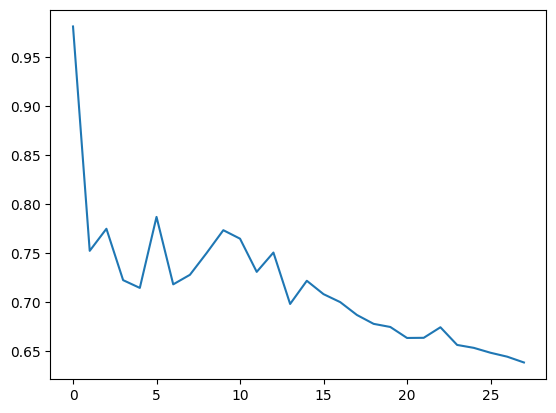

In [ ]:
plt.plot(loss_history)

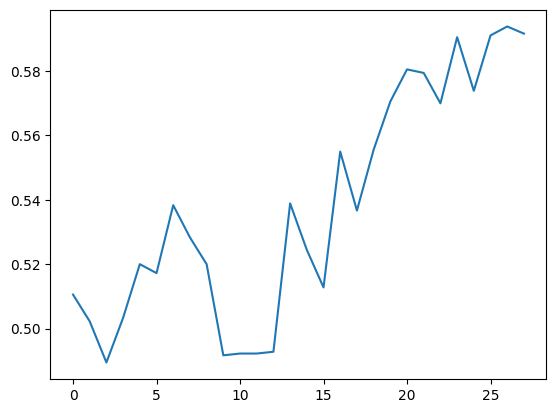

In [ ]:
plt.plot(train_acc_history)

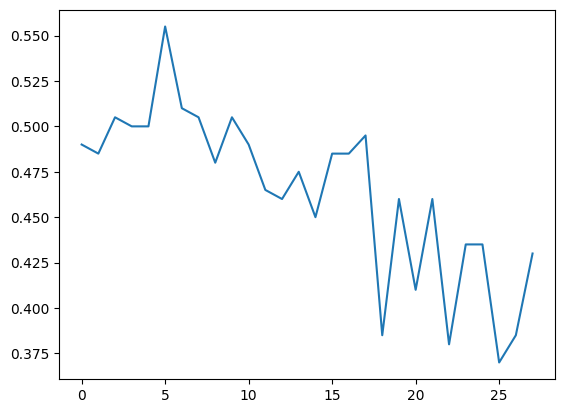

In [ ]:
plt.plot(test_acc_history)

In [ ]:
def is_state_dict_identical(state_dict1, state_dict2):
    return all([(state_dict1[key] == state_dict2[key]).all() for key in state_dict1])

In [ ]:
is_state_dict_identical(vision_encoder.state_dict(), torch.load('init_vision_encoder.pt'))

False

In [ ]:
is_state_dict_identical(classifier.state_dict(), torch.load('init_classifier.pt'))

False

In [ ]:
is_state_dict_identical(image_emb_compressor.state_dict(), torch.load('init_image_emb_compressor.pt'))

False

In [ ]:
is_state_dict_identical(llm_model.state_dict(), torch.load('init_llm_model.pt'))

True